In [1]:
import pyemu
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import flopy as fp
from flopy.utils.reference import SpatialReference
import os
import sys
from shutil import copyfile
import fileinput

sys.path.append("../../modules")
# hand made functions
from Rouss import *

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


In [2]:
ws = "workspace"
m_n_i = "pest_3d_r"
m_n = "pest_3D_R"

case = "3D_test"

In [3]:
sim = fp.mf6.MFSimulation.load(sim_ws=ws)
m = sim.get_model(m_n_i)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package wel...
    loading package rch...
    loading package rch...
    loading package rch...
    loading package wel...
    loading package chd...
    loading package chd...
    loading package drn...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package obs...
  loading ims package pest_3d_r...


In [4]:
sr = SpatialReference(delr=m.dis.delr.array, delc=m.dis.delc.array, xll=m.dis.xorigin.array, yll=m.dis.yorigin.array)
sr

xul:664525; yul:6207475; rotation:0; proj4_str:None; units:meters; lenuni:2; length_multiplier:1.0

In [5]:
# empty pst object
template_ws = "template"
pf = pyemu.prototypes.PstFrom(original_d=ws, new_d=template_ws,
                 remove_existing=True,
                 longnames=True, spatial_reference=sr,
                 zero_based=False)

2020-07-05 15:46:36.238144 starting: opening PstFrom.log for logging
2020-07-05 15:46:36.238144 starting PstFrom process
2020-07-05 15:46:36.246176 starting: setting up dirs
2020-07-05 15:46:36.248199 starting: removing existing new_d 'template'
2020-07-05 15:46:36.276362 finished: removing existing new_d 'template' took: 0:00:00.028163
2020-07-05 15:46:36.276362 starting: copying original_d 'workspace' to new_d 'template'
2020-07-05 15:46:36.449669 finished: copying original_d 'workspace' to new_d 'template' took: 0:00:00.173307
2020-07-05 15:46:36.449669 finished: setting up dirs took: 0:00:00.203493


In [6]:
#add observation

#Quat
df = pd.read_csv(os.path.join(template_ws,"heads_q.csv"),index_col=0)
hds_df = pf.add_observations("heads_q.csv",insfile="heads_q.csv.ins",index_cols="time",
                use_cols=list(df.columns.values),prefix="quat",obsgp=True)
#P
df = pd.read_csv(os.path.join(template_ws,"heads_pc.csv"),index_col=0)
hds_df = pf.add_observations("heads_pc.csv",insfile="heads_pc.csv.ins",index_cols="time",
                use_cols=list(df.columns.values),prefix="pc",obsgp=True)

2020-07-05 15:46:36.510110 starting: adding observations from tabular output file
2020-07-05 15:46:36.510110 starting: reading list template\heads_q.csv
2020-07-05 15:46:36.520210 finished: reading list template\heads_q.csv took: 0:00:00.010100
2020-07-05 15:46:36.520210 starting: building insfile for tabular output file heads_q.csv
2020-07-05 15:46:36.560517 finished: building insfile for tabular output file heads_q.csv took: 0:00:00.040307
2020-07-05 15:46:36.560517 starting: adding observation from instruction file 'template\heads_q.csv.ins'
2020-07-05 15:46:36.590744 finished: adding observation from instruction file 'template\heads_q.csv.ins' took: 0:00:00.030227
2020-07-05 15:46:36.598827 finished: adding observations from tabular output file took: 0:00:00.088717
2020-07-05 15:46:36.608883 starting: adding observations from tabular output file
2020-07-05 15:46:36.608883 starting: reading list template\heads_pc.csv
2020-07-05 15:46:36.610910 finished: reading list template\heads_p

In [7]:
def chInsfle(file):
    
    """
    change a ins file create with PstFrom (only for a model with 1 stress period)
    in the right format to be used by PEST
    """
    
    fileout = "tmp"
    with open(file) as f:
        with open(fileout,"w") as fout:
            for i,line in enumerate(f):
                if i < 2:
                    fout.write(line)
                if i > 1:
                    for o,split in enumerate(line.split("w")):
                        if o == 1:
                            fout.write("~,~")
                        fout.write(split)
                        
    from shutil import copyfile
    copyfile(fileout, file) # copy 
    os.remove(fileout) # delete tmp file

chInsfle("template/heads_pc.csv.ins")
chInsfle("template/heads_q.csv.ins")

pf.obs_dfs[0].obgnme = "Quat"
pf.obs_dfs[1].obgnme = "Pc"

In [8]:
pf.build_pst("{}.pst".format(case))

noptmax:30, npar_adj:0, nnz_obs:122


### Parameters

C:\Users\emmal\Anaconda3\lib\site-packages\pyemu\utils\geostats.py:244: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


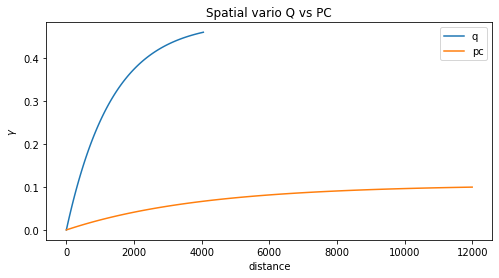

In [9]:
fig,ax = plt.subplots(figsize=(8,4))

#q
vq = pyemu.geostats.ExpVario(a=1350,contribution=0.485)
grid_q = pyemu.geostats.GeoStruct(variograms=vq, transform='log')
b=grid_q.plot()

#pc
vp = pyemu.geostats.ExpVario(a=4000,contribution=0.105)
grid_pc = pyemu.geostats.GeoStruct(variograms=vp, transform='log')
a=grid_pc.plot()

a.set_title("Spatial vario Q vs PC")
plt.legend(["q","pc"])

2020-07-05 15:46:38.123654 starting: adding pilotpoint type multiplier style parameters for file(s) ['kq.txt']
2020-07-05 15:46:38.123654 starting: loading array template\kq.txt
2020-07-05 15:46:38.204190 finished: loading array template\kq.txt took: 0:00:00.080536
2020-07-05 15:46:38.204190 loaded array 'kq.txt' of shape (182, 183)
2020-07-05 15:46:38.294843 starting: writing array-based template file 'kp_q_inst0_pilotpoint.csv.tpl'
2020-07-05 15:46:38.294843 starting: setting up pilot point parameters
2020-07-05 15:46:38.294843 No spatial reference (containing cell spacing) passed.
2020-07-05 15:46:38.294843 OK - using spatial reference in parent object.
2020-07-05 15:46:38.848890 83 pilot point parameters created
2020-07-05 15:46:38.848890 pilot point 'pargp':kp_q_inst:0
2020-07-05 15:46:38.848890 finished: setting up pilot point parameters took: 0:00:00.554047
2020-07-05 15:46:38.889158 starting: calculating factors for pargp=kp_q_inst:0
2020-07-05 15:46:38.889158 saving krige vari

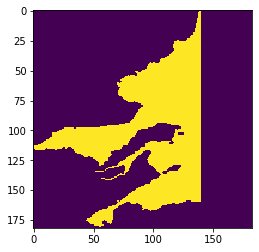

In [10]:
## pp quat
zq = m.dis.idomain.array[1] # zone array for pp
zq[:,140:]=0
zq[zq<0]=0
plt.imshow(zq)

pf.add_parameters(filenames="kq.txt",par_type="pilotpoint",pp_space=10,zone_array=zq,
                   par_name_base="kp_q",pargp="pp_q",
                   upper_bound=3,lower_bound=0.005,ult_ubound=5e-3,ult_lbound=1e-5,geostruct=grid_q)

2020-07-05 15:48:01.643503 starting: adding pilotpoint type multiplier style parameters for file(s) ['kpc.txt']
2020-07-05 15:48:01.643503 starting: loading array template\kpc.txt
2020-07-05 15:48:01.716066 finished: loading array template\kpc.txt took: 0:00:00.072563
2020-07-05 15:48:01.716066 loaded array 'kpc.txt' of shape (182, 183)
2020-07-05 15:48:01.794511 starting: writing array-based template file 'kp_pc_inst0_pilotpoint.csv.tpl'
2020-07-05 15:48:01.794511 starting: setting up pilot point parameters
2020-07-05 15:48:01.796536 No spatial reference (containing cell spacing) passed.
2020-07-05 15:48:01.796536 OK - using spatial reference in parent object.
2020-07-05 15:48:02.401157 110 pilot point parameters created
2020-07-05 15:48:02.401157 pilot point 'pargp':kp_pc_inst:0
2020-07-05 15:48:02.401157 finished: setting up pilot point parameters took: 0:00:00.606646
2020-07-05 15:48:02.441473 starting: calculating factors for pargp=kp_pc_inst:0
2020-07-05 15:48:02.441473 saving kr

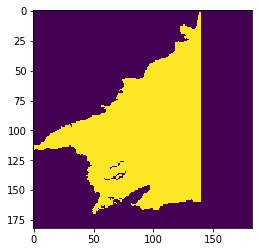

In [11]:
## pp pc
zpc = m.dis.idomain.array[3] # zone array for pp
zpc[:,140:]=0
zpc[zpc<0]=0
plt.imshow(zpc)

pf.add_parameters(filenames="kpc.txt",par_type="pilotpoint",pp_space=10,zone_array=zpc,
                   par_name_base="kp_pc",pargp="pp_pc",
                   upper_bound=4,lower_bound=0.001,ult_ubound=3e-4,ult_lbound=1e-6,geostruct=grid_pc)

2020-07-05 15:49:28.539612 starting: adding zone type multiplier style parameters for file(s) ['irr.txt']
2020-07-05 15:49:28.539612 starting: loading array template\irr.txt
2020-07-05 15:49:28.597983 finished: loading array template\irr.txt took: 0:00:00.058371
2020-07-05 15:49:28.597983 loaded array 'irr.txt' of shape (182, 183)
2020-07-05 15:49:28.650270 starting: writing array-based template file 'irr_inst0_zone.csv.tpl'
2020-07-05 15:49:28.650270 starting: writing template file irr_inst0_zone.csv.tpl for ['irr_inst:0']
2020-07-05 15:49:28.821528 finished: writing template file irr_inst0_zone.csv.tpl for ['irr_inst:0'] took: 0:00:00.171258
2020-07-05 15:49:28.821528 finished: writing array-based template file 'irr_inst0_zone.csv.tpl' took: 0:00:00.171258
2020-07-05 15:49:28.841679 starting: adding parameters for file(s) ['irr.txt']


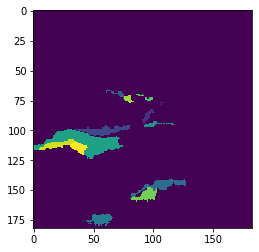

In [12]:
#irri
zi = np.loadtxt(os.path.join(ws,"zone_irr.txt"))
plt.imshow(zi)
pf.add_parameters(filenames="irr.txt",par_type="zone",zone_array=zi,
                   par_name_base="irr",pargp="irr",
                   upper_bound=2,lower_bound=0.8)

In [ ]:
# kpms and kep
pf.add_parameters(filenames="kep.txt",par_type="constant",
                   par_name_base="ep",pargp="ep",
                   upper_bound=10,lower_bound=0.1)
pf.add_parameters(filenames="kpms.txt",par_type="constant",
                 par_name_base="pms",pargp="pms",upper_bound=30,lower_bound=0.1)

### rivers

In [13]:
rivers = [riv for riv in os.listdir(template_ws) if riv.endswith("riv")]

In [14]:
def riv_tpl(rivers,tmp_ws):
    for riv in rivers:
        riv_file = os.path.join(tmp_ws,riv)
        tpl_file = riv_file+".tpl"
        copyfile(riv_file, tpl_file)
        
        with fileinput.FileInput(tpl_file, inplace=True) as file:
            for line in file:
                print(line.replace("    0.00500000   ", "~    c_{}     ~".format(riv.split(".")[0])), end='')
        with open(tpl_file, 'r+') as f:
            content = f.read()
            line = "ptf ~"
            f.seek(0, 0)
            f.write(line.rstrip('\r\n') + "\n" + content)
        
        #add parameter to control file
        dic = {"parnme":"c_{}".format(riv.split(".")[0]),
              "parval1": 0.005,
               "pargp": "cond",
               "tpl_filename": tpl_file,
               'input_filename':riv_file,
               "partype" : "constant",
               "partrans" : "log",
               "parubnd" : 0.01,
               "parlbnd" : 0.001,
               "parchglim" : "factor",
               "scale" : 1.0,
               "dercom" : 1,
               "offset" : 0.0} 
        a = pd.DataFrame(dic,index=["c_{}".format(riv.split(".")[0])])
        pf.par_dfs[0] = pf.par_dfs[0].append(a,sort=False)
        
        pf.tpl_filenames.append(riv+".tpl")
        pf.input_filenames.append(riv)

In [15]:
riv_tpl(rivers,template_ws)

In [16]:
pf.build_pst("{}.pst".format(case))

C:\Users\emmal\Anaconda3\lib\site-packages\pyemu\prototypes\pst_from.py:472: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  par_data = pd.concat(self.par_dfs).loc[:, par_data_cols]
C:\Users\emmal\Anaconda3\lib\site-packages\pyemu\prototypes\pst_from.py:127: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  ignore_index=True)


noptmax:30, npar_adj:213, nnz_obs:122


In [17]:
# add run model command
pf.mod_sys_cmds.append("..\..\..\exe\mf6")
pst = pf.build_pst("{}.pst".format(case))

noptmax:30, npar_adj:213, nnz_obs:122
2020-07-05 15:49:30.221997 forward_run line:pyemu.os_utils.run(r'..\..\..\exe\mf6')



2020-07-05 15:49:30.282439 starting: building prior covariance matrix
2020-07-05 15:49:30.411275 saving prior covariance matrix to file template\3D_test.prior.cov
2020-07-05 15:49:30.463591 finished: building prior covariance matrix took: 0:00:00.181152


C:\Users\emmal\Anaconda3\lib\site-packages\pyemu\utils\helpers.py:248: UserWarning: geostatistical_prior_builder() warning: geostruct sill != 1.0, user beware!
  warnings.warn("geostatistical_prior_builder() warning: geostruct sill != 1.0, user beware!")


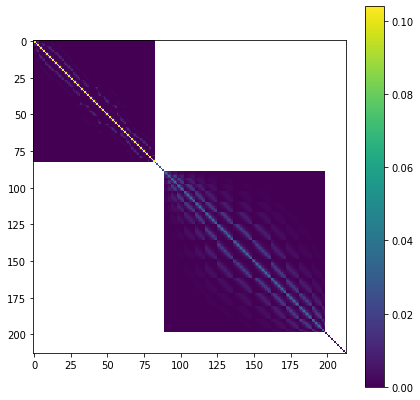

In [18]:
cov = pf.build_prior()
x = cov.x.copy()
x[x==0.0] = np.NaN
fig,ax = plt.subplots(1,1,figsize=(7,7))
g = ax.imshow(x)
plt.colorbar(g)

In [19]:
pst.control_data.noptmax = -1 # FOR JACOBIAN
pst.write(os.path.join(template_ws,"{}.pst".format(case)))

noptmax:-1, npar_adj:213, nnz_obs:122


In [20]:
# pyemu.os_utils.run("..\..\pestpp-glm.exe {}".format(case),cwd="template")

In [22]:
m_d = "master_glm"

pyemu.os_utils.start_workers(template_ws,"../../pestpp-glm.exe","{}.pst".format(case),num_workers=8,worker_root=".",master_dir=m_d)